In [1]:
import tensorflow as tf
import kagglehub
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam

c:\Users\jpfal\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
path += '\data'

In [70]:
# Adjust image_size for InceptionV3 (299x299)
train_dataset = image_dataset_from_directory(
    path,
    image_size=(299, 299),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42,
    shuffle=True
)


val_dataset = image_dataset_from_directory(
    path,
    image_size=(299, 299),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

class_names = train_dataset.class_names
print(class_names)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.
['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [71]:
# Image preprocessing
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))

In [72]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

base_model.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [73]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.8030 - loss: 0.5099 - val_accuracy: 0.8507 - val_loss: 0.3372
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.8800 - loss: 0.3161 - val_accuracy: 0.8996 - val_loss: 0.2677
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.8899 - loss: 0.2677 - val_accuracy: 0.8877 - val_loss: 0.2713
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9006 - loss: 0.2486 - val_accuracy: 0.9092 - val_loss: 0.2383
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.9045 - loss: 0.2395 - val_accuracy: 0.8984 - val_loss: 0.2564
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9093 - loss: 0.2236 - val_accuracy: 0.9104 - val_loss: 0.2189
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 685s 7s/step - accuracy: 0.9167 - loss: 0.2082 - val_accuracy: 0.9116 - val_loss: 0.2333
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9152 - loss: 0.2087 - val_accu

In [74]:
base_model.trainable = True

# Fine tune from this layer onwards
fine_tune_at = 250

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 538s 5s/step - accuracy: 0.8759 - loss: 0.3189 - val_accuracy: 0.9176 - val_loss: 0.2117
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9290 - loss: 0.2061 - val_accuracy: 0.9235 - val_loss: 0.2005
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - accuracy: 0.9373 - loss: 0.1820 - val_accuracy: 0.9355 - val_loss: 0.1878
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.9311 - loss: 0.1699 - val_accuracy: 0.9367 - val_loss: 0.1779
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9436 - loss: 0.1483 - val_accuracy: 0.9498 - val_loss: 0.1672


In [75]:
model.evaluate(val_dataset)

model.save("InceptionV3_Corn_Model.keras")

27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9498 - loss: 0.1672


In [76]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

X_val = []
y_true = []

for batch_x, batch_y in val_dataset:
    X_val.append(batch_x.numpy())
    y_true.append(batch_y.numpy())

X_val = np.concatenate(X_val)
y_true = np.concatenate(y_true)

# Predict on numpy array instead of dataset
preds = model.predict(X_val)
y_pred = np.argmax(preds, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step
Classification Report:
                precision    recall  f1-score   support

        Blight       0.90      0.94      0.92       225
   Common_Rust       0.97      0.99      0.98       244
Gray_Leaf_Spot       0.91      0.79      0.85       126
       Healthy       1.00      1.00      1.00       242

      accuracy                           0.95       837
     macro avg       0.94      0.93      0.94       837
  weighted avg       0.95      0.95      0.95       837


Confusion Matrix:
[[212   4   9   0]
 [  1 242   1   0]
 [ 22   4 100   0]
 [  1   0   0 241]]


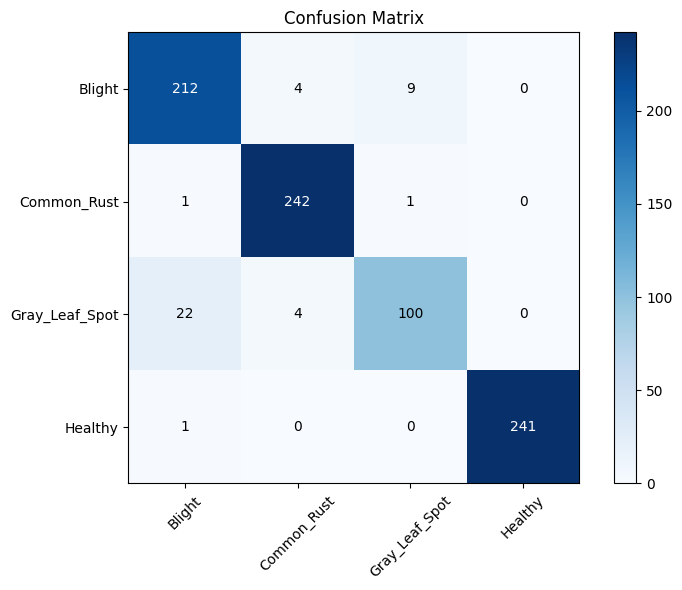

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

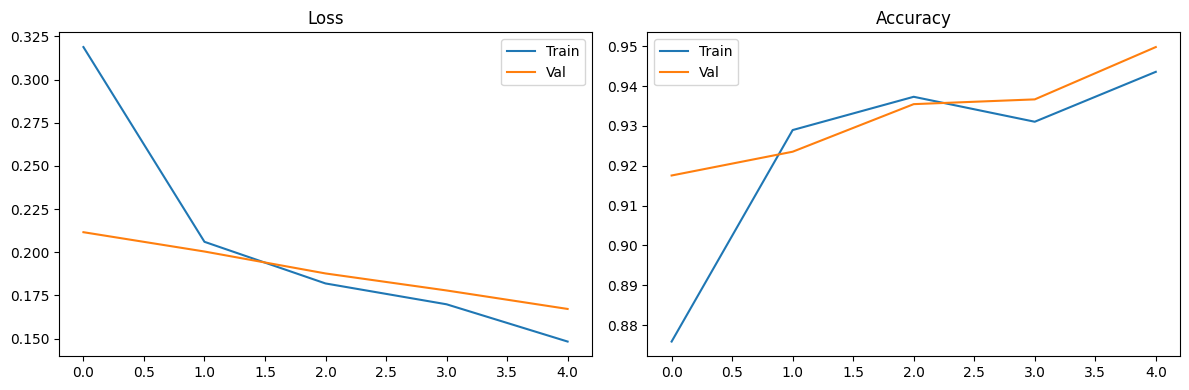

In [78]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_fine.history['loss'], label='Train')
plt.plot(history_fine.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Train')
plt.plot(history_fine.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()